
Veri Seti İstatistikleri:
Toplam Araç Sayısı: 1870
Minimum Fiyat: 2.45 TL
Maksimum Fiyat: 56.49 TL
Ortalama Fiyat: 17.24 TL
Medyan Fiyat: 15.95 TL

Özellik Önem Dereceleri:
             feature  importance
2               year    0.638565
4                 hp    0.233778
0       Km_thousands    0.107328
1       gear_encoded    0.011991
3  fuel_type_encoded    0.008338

=== Volkswagen Golf Fiyat Tahmini ===


Kilometreyi girin:  50000
Yılı girin (örn. 2013):  2022
Beygir gücünü girin:  120



Vites tipi için:
1 - Manuel
2 - Otomatik


Vites tipini seçin (1 veya 2):  1



Yakıt tipi için:
1 - Benzin
2 - Dizel


Yakıt tipini seçin (1 veya 2):  1


C:\Users\GOK\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(



=== Tahmin Sonuçları ===
Girilen Değerler:
Kilometre: 50,000
Yıl: 2022
Beygir Gücü: 120.0
Vites: Manual
Yakıt: Gasoline

Tahmini Fiyat: 18.36 TL


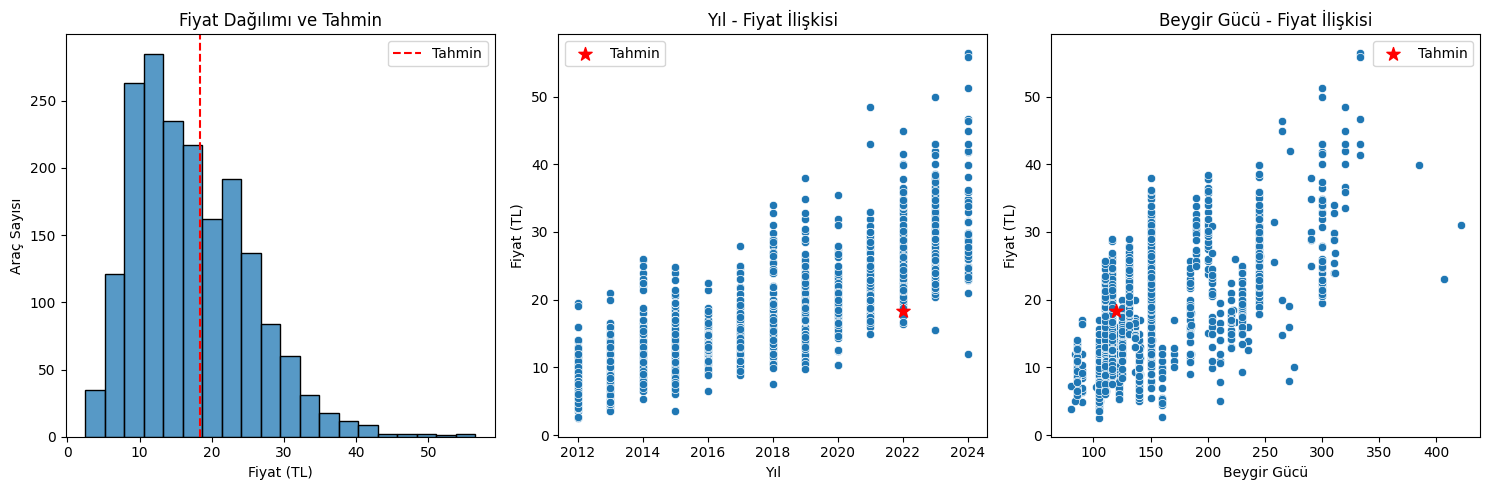


Model Performans Metrikleri:
R2 Score: 0.9343
RMSE: 2.16 TL


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Veriyi oku
df = pd.read_excel('cleaned_data.xlsx')

# Veri temizleme ve düzenleme
def preprocess_data(df):
    # Veri setinin bir kopyasını oluştur
    df = df.copy()
    
    # Vites tiplerini standartlaştır
    gear_mapping = {
        'Automatic': 'Automatic',
        'Manual': 'Manual',
        'Semi-automatic': 'Automatic'
    }
    df['gear'] = df['gear'].map(gear_mapping)
    
    # Yakıt tiplerini standartlaştır
    fuel_mapping = {
        'Gasoline': 'Gasoline',
        'Diesel': 'Diesel'
    }
    df['fuel_type'] = df['fuel_type'].map(fuel_mapping)
    
    # Kategorik değişkenleri dönüştür
    le_gear = LabelEncoder()
    le_fuel = LabelEncoder()
    
    df['gear_encoded'] = le_gear.fit_transform(df['gear'])
    df['fuel_type_encoded'] = le_fuel.fit_transform(df['fuel_type'])
    
    # Yaş hesapla
    df['age'] = 2024 - df['year']
    
    # Km'yi 1000'e bölerek ölçeği küçült
    df['Km_thousands'] = df['Km'] / 1000
    
    return df, le_gear, le_fuel

# Veriyi temizle ve dönüştür
df, le_gear, le_fuel = preprocess_data(df)

# Features ve target
X = df[['Km_thousands', 'gear_encoded', 'year', 'fuel_type_encoded', 'hp']]
y = df['price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ölçeklendirme
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

# Model eğitimi
model.fit(X_train_scaled, y_train)

def predict_price(km, gear_type, year, fuel_type, hp):
    try:
        # Veriyi hazırla
        km_thousands = km / 1000
        
        # Kategorik değişkenleri dönüştür
        gear_encoded = le_gear.transform([gear_type])[0]
        fuel_encoded = le_fuel.transform([fuel_type])[0]
        
        # Input array oluştur
        input_data = np.array([[km_thousands, gear_encoded, year, fuel_encoded, hp]])
        
        # Ölçeklendir
        input_scaled = scaler.transform(input_data)
        
        # Tahmin yap
        predicted_price = model.predict(input_scaled)[0]
        
        # Minimum ve maksimum fiyat sınırları
        min_price = df['price'].min()
        max_price = df['price'].max()
        
        return np.clip(predicted_price, min_price, max_price)
        
    except Exception as e:
        print(f"Tahmin sırasında hata oluştu: {e}")
        return None

def get_user_input_and_predict():
    try:
        print("\n=== Volkswagen Golf Fiyat Tahmini ===")
        km = float(input("Kilometreyi girin: "))
        year = int(input("Yılı girin (örn. 2013): "))
        hp = float(input("Beygir gücünü girin: "))
        
        print("\nVites tipi için:")
        print("1 - Manuel")
        print("2 - Otomatik")
        gear_choice = int(input("Vites tipini seçin (1 veya 2): "))
        gear_type = 'Manual' if gear_choice == 1 else 'Automatic'
        
        print("\nYakıt tipi için:")
        print("1 - Benzin")
        print("2 - Dizel")
        fuel_choice = int(input("Yakıt tipini seçin (1 veya 2): "))
        fuel_type = 'Gasoline' if fuel_choice == 1 else 'Diesel'
        
        # Benzer araçları bul
        similar_cars = df[
            (df['year'] == year) & 
            (abs(df['hp'] - hp) <= 20) & 
            (abs(df['Km_thousands'] - km/1000) <= 30)
        ]
        
        predicted_price = predict_price(km, gear_type, year, fuel_type, hp)
        
        if predicted_price is not None:
            print("\n=== Tahmin Sonuçları ===")
            print(f"Girilen Değerler:")
            print(f"Kilometre: {km:,.0f}")
            print(f"Yıl: {year}")
            print(f"Beygir Gücü: {hp}")
            print(f"Vites: {gear_type}")
            print(f"Yakıt: {fuel_type}")
            print(f"\nTahmini Fiyat: {predicted_price:,.2f} TL")
            
            if not similar_cars.empty:
                print("\nBenzer Araçların Fiyatları:")
                print(f"Minimum: {similar_cars['price'].min():,.2f} TL")
                print(f"Maksimum: {similar_cars['price'].max():,.2f} TL")
                print(f"Ortalama: {similar_cars['price'].mean():,.2f} TL")
            
            # Görselleştirme
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            sns.histplot(data=df, x='price', bins=20)
            plt.axvline(x=predicted_price, color='r', linestyle='--', label='Tahmin')
            plt.xlabel('Fiyat (TL)')
            plt.ylabel('Araç Sayısı')
            plt.title('Fiyat Dağılımı ve Tahmin')
            plt.legend()
            
            plt.subplot(1, 3, 2)
            sns.scatterplot(data=df, x='year', y='price')
            plt.scatter(year, predicted_price, color='red', s=100, marker='*', label='Tahmin')
            plt.xlabel('Yıl')
            plt.ylabel('Fiyat (TL)')
            plt.title('Yıl - Fiyat İlişkisi')
            plt.legend()
            
            plt.subplot(1, 3, 3)
            sns.scatterplot(data=df, x='hp', y='price')
            plt.scatter(hp, predicted_price, color='red', s=100, marker='*', label='Tahmin')
            plt.xlabel('Beygir Gücü')
            plt.ylabel('Fiyat (TL)')
            plt.title('Beygir Gücü - Fiyat İlişkisi')
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            # Model performansını göster
            y_pred = model.predict(X_test_scaled)
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            print(f"\nModel Performans Metrikleri:")
            print(f"R2 Score: {r2:.4f}")
            print(f"RMSE: {rmse:,.2f} TL")
            
    except ValueError as e:
        print(f"\nHata: Lütfen geçerli değerler girin!")
    except Exception as e:
        print(f"\nBir hata oluştu: {e}")

# Veri seti istatistiklerini göster
print("\nVeri Seti İstatistikleri:")
print(f"Toplam Araç Sayısı: {len(df)}")
print(f"Minimum Fiyat: {df['price'].min():,.2f} TL")
print(f"Maksimum Fiyat: {df['price'].max():,.2f} TL")
print(f"Ortalama Fiyat: {df['price'].mean():,.2f} TL")
print(f"Medyan Fiyat: {df['price'].median():,.2f} TL")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
})
print("\nÖzellik Önem Dereceleri:")
print(feature_importance.sort_values('importance', ascending=False))

# Tahmin yap
get_user_input_and_predict()